In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/glass')
mask_dir = os.path.join(dataset_dir,'mask/glass')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/glass C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/glass
13135
13135


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-15 14:26:46,352: INFO: 3804955329: date_time: 20250215-142646]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "linknet",
    "backbone" : "vgg16", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-15 14:26:46,512: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-15 14:26:46,514: INFO: 342151172: model_config: {'model_name': 'linknet', 'backbone': 'vgg16', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-15 14:26:46,516: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-15 14:26:46,518: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

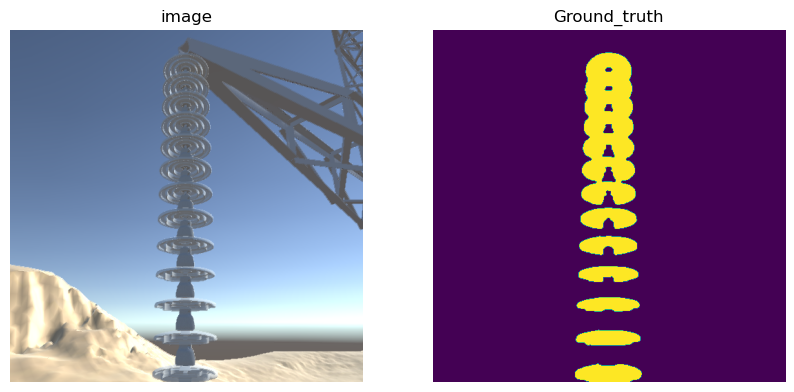

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-15 14:26:47,048: INFO: 3993860970: data injection started]
[2025-02-15 14:26:47,050: INFO: 3993860970: train data spliting ]
[2025-02-15 14:26:47,052: INFO: 3993860970: val test spliting ]
[2025-02-15 14:26:47,054: INFO: 3993860970: csv saving started]
[2025-02-15 14:26:47,086: INFO: 3993860970: train csv done ]
[2025-02-15 14:26:47,091: INFO: 3993860970: val csv done ]
[2025-02-15 14:26:47,096: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 1752/1752 [08:03<00:00,  3.62it/s, epoch=0, train_loss=0.0246, train_Miou_score=0.545, train_dice_score=0.639, train_acc=0.991, train_binary_jaccard_index=0.882, train_dice_coefficient=0.933] 

[2025-02-15 14:35:43,821: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.02455759691457226]
[2025-02-15 14:35:43,822: INFO: 2273413975: train_loss 0.07027019550582024]
[2025-02-15 14:35:43,823: INFO: 2273413975: train_Miou_score 0.5451501564071705]
[2025-02-15 14:35:43,823: INFO: 2273413975: train_dice_score 0.6392150198730862]
[2025-02-15 14:35:43,824: INFO: 2273413975: train_acc 0.991166754468391]
[2025-02-15 14:35:43,824: INFO: 2273413975: train_binary_jaccard_index: 0.8815727741840257]
[2025-02-15 14:35:43,825: INFO: 2273413975: train_dice_coefficient: 0.9330607928896397]



100%|██████████| 657/657 [00:41<00:00, 16.00it/s, epoch=0, eval_loss=0.00485, eval_Miou_score=0.569, eval_dice_score=0.717, eval_acc=0.996, eval_binary_jaccard_index=0.921, eval_dice_coefficient=0.958]

[2025-02-15 14:36:24,903: INFO: 2273413975: Epoch: 0 | Loss: 0.004850824220358327]
[2025-02-15 14:36:24,903: INFO: 2273413975: eval_loss 0.004812552741831355]
[2025-02-15 14:36:24,904: INFO: 2273413975: eval_Miou_score 0.5686767742922317]
[2025-02-15 14:36:24,905: INFO: 2273413975: eval_dice_score 0.7170128034855858]
[2025-02-15 14:36:24,905: INFO: 2273413975: eval_acc 0.995622594244041]
[2025-02-15 14:36:24,906: INFO: 2273413975: eval_binary_jaccard_index: 0.9212687442155734]
[2025-02-15 14:36:24,907: INFO: 2273413975: eval_dice_coefficient: 0.9576992332831371]



100%|██████████| 1752/1752 [07:34<00:00,  3.86it/s, epoch=1, train_loss=0.00447, train_Miou_score=0.558, train_dice_score=0.678, train_acc=0.993, train_binary_jaccard_index=0.905, train_dice_coefficient=0.948]

[2025-02-15 14:43:59,313: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.0044686260833043485]
[2025-02-15 14:43:59,314: INFO: 2273413975: train_loss 0.03755212261036457]
[2025-02-15 14:43:59,315: INFO: 2273413975: train_Miou_score 0.558203251193571]
[2025-02-15 14:43:59,315: INFO: 2273413975: train_dice_score 0.678345941660578]
[2025-02-15 14:43:59,316: INFO: 2273413975: train_acc 0.9934605460903144]
[2025-02-15 14:43:59,316: INFO: 2273413975: train_binary_jaccard_index: 0.9053833197523758]
[2025-02-15 14:43:59,317: INFO: 2273413975: train_dice_coefficient: 0.9479106889242919]



100%|██████████| 657/657 [00:39<00:00, 16.74it/s, epoch=1, eval_loss=0.00531, eval_Miou_score=0.564, eval_dice_score=0.707, eval_acc=0.995, eval_binary_jaccard_index=0.917, eval_dice_coefficient=0.955]

[2025-02-15 14:44:38,564: INFO: 2273413975: Epoch: 1 | Loss: 0.005306704312880471]
[2025-02-15 14:44:38,564: INFO: 2273413975: eval_loss 0.005044328712390929]
[2025-02-15 14:44:38,565: INFO: 2273413975: eval_Miou_score 0.5639678964694704]
[2025-02-15 14:44:38,566: INFO: 2273413975: eval_dice_score 0.7071497077675171]
[2025-02-15 14:44:38,567: INFO: 2273413975: eval_acc 0.9952115359371656]
[2025-02-15 14:44:38,568: INFO: 2273413975: eval_binary_jaccard_index: 0.9169202827858417]
[2025-02-15 14:44:38,569: INFO: 2273413975: eval_dice_coefficient: 0.9553285503770715]



100%|██████████| 1752/1752 [07:33<00:00,  3.86it/s, epoch=2, train_loss=0.00368, train_Miou_score=0.564, train_dice_score=0.699, train_acc=0.994, train_binary_jaccard_index=0.917, train_dice_coefficient=0.955]

[2025-02-15 14:52:12,100: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.0036806220605493135]
[2025-02-15 14:52:12,101: INFO: 2273413975: train_loss 0.026242758307084574]
[2025-02-15 14:52:12,102: INFO: 2273413975: train_Miou_score 0.5644804594019085]
[2025-02-15 14:52:12,103: INFO: 2273413975: train_dice_score 0.6994371797760652]
[2025-02-15 14:52:12,105: INFO: 2273413975: train_acc 0.9944341959746461]
[2025-02-15 14:52:12,106: INFO: 2273413975: train_binary_jaccard_index: 0.9165642064077499]
[2025-02-15 14:52:12,108: INFO: 2273413975: train_dice_coefficient: 0.9546283496198964]



100%|██████████| 657/657 [00:38<00:00, 16.88it/s, epoch=2, eval_loss=0.00298, eval_Miou_score=0.571, eval_dice_score=0.726, eval_acc=0.996, eval_binary_jaccard_index=0.926, eval_dice_coefficient=0.961]

[2025-02-15 14:52:51,039: INFO: 2273413975: Epoch: 2 | Loss: 0.0029799813004933538]
[2025-02-15 14:52:51,039: INFO: 2273413975: eval_loss 0.004319870609393429]
[2025-02-15 14:52:51,040: INFO: 2273413975: eval_Miou_score 0.5714899858867136]
[2025-02-15 14:52:51,040: INFO: 2273413975: eval_dice_score 0.7260989407516869]
[2025-02-15 14:52:51,041: INFO: 2273413975: eval_acc 0.9958250577046991]
[2025-02-15 14:52:51,042: INFO: 2273413975: eval_binary_jaccard_index: 0.9260098657999348]
[2025-02-15 14:52:51,042: INFO: 2273413975: eval_dice_coefficient: 0.9605413205174658]



100%|██████████| 1752/1752 [07:33<00:00,  3.86it/s, epoch=3, train_loss=0.00399, train_Miou_score=0.567, train_dice_score=0.71, train_acc=0.995, train_binary_jaccard_index=0.921, train_dice_coefficient=0.957] 

[2025-02-15 15:00:24,794: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.0039887448015822665]
[2025-02-15 15:00:24,794: INFO: 2273413975: train_loss 0.0204862378752627]
[2025-02-15 15:00:24,795: INFO: 2273413975: train_Miou_score 0.5674852409828497]
[2025-02-15 15:00:24,797: INFO: 2273413975: train_dice_score 0.7098742022456683]
[2025-02-15 15:00:24,797: INFO: 2273413975: train_acc 0.9948365052813264]
[2025-02-15 15:00:24,799: INFO: 2273413975: train_binary_jaccard_index: 0.9214828603089783]
[2025-02-15 15:00:24,799: INFO: 2273413975: train_dice_coefficient: 0.9574497066451652]



100%|██████████| 657/657 [00:39<00:00, 16.74it/s, epoch=3, eval_loss=0.00349, eval_Miou_score=0.574, eval_dice_score=0.732, eval_acc=0.996, eval_binary_jaccard_index=0.929, eval_dice_coefficient=0.962]

[2025-02-15 15:01:04,051: INFO: 2273413975: Epoch: 3 | Loss: 0.003485194261397038]
[2025-02-15 15:01:04,051: INFO: 2273413975: eval_loss 0.004085132291535354]
[2025-02-15 15:01:04,052: INFO: 2273413975: eval_Miou_score 0.5743760466915832]
[2025-02-15 15:01:04,053: INFO: 2273413975: eval_dice_score 0.7318742413929972]
[2025-02-15 15:01:04,054: INFO: 2273413975: eval_acc 0.996003063120617]
[2025-02-15 15:01:04,054: INFO: 2273413975: eval_binary_jaccard_index: 0.9290437932825071]
[2025-02-15 15:01:04,054: INFO: 2273413975: eval_dice_coefficient: 0.9622993564020607]



100%|██████████| 1752/1752 [07:35<00:00,  3.85it/s, epoch=4, train_loss=0.00318, train_Miou_score=0.57, train_dice_score=0.719, train_acc=0.995, train_binary_jaccard_index=0.926, train_dice_coefficient=0.96] 

[2025-02-15 15:08:39,212: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.0031757754141881586]
[2025-02-15 15:08:39,212: INFO: 2273413975: train_loss 0.017022479590651677]
[2025-02-15 15:08:39,213: INFO: 2273413975: train_Miou_score 0.5704114539859195]
[2025-02-15 15:08:39,214: INFO: 2273413975: train_dice_score 0.7186706228065305]
[2025-02-15 15:08:39,215: INFO: 2273413975: train_acc 0.9952369474316841]
[2025-02-15 15:08:39,215: INFO: 2273413975: train_binary_jaccard_index: 0.926437852649469]
[2025-02-15 15:08:39,216: INFO: 2273413975: train_dice_coefficient: 0.9604058132262737]



100%|██████████| 657/657 [00:39<00:00, 16.51it/s, epoch=4, eval_loss=0.00339, eval_Miou_score=0.575, eval_dice_score=0.736, eval_acc=0.996, eval_binary_jaccard_index=0.931, eval_dice_coefficient=0.963]

[2025-02-15 15:09:19,003: INFO: 2273413975: Epoch: 4 | Loss: 0.00339038431916607]
[2025-02-15 15:09:19,004: INFO: 2273413975: eval_loss 0.003948315999193049]
[2025-02-15 15:09:19,004: INFO: 2273413975: eval_Miou_score 0.5753358369004237]
[2025-02-15 15:09:19,005: INFO: 2273413975: eval_dice_score 0.7355274215680824]
[2025-02-15 15:09:19,006: INFO: 2273413975: eval_acc 0.9961262765358935]
[2025-02-15 15:09:19,006: INFO: 2273413975: eval_binary_jaccard_index: 0.9307925862400499]
[2025-02-15 15:09:19,007: INFO: 2273413975: eval_dice_coefficient: 0.9633504441227769]



100%|██████████| 1752/1752 [07:33<00:00,  3.86it/s, epoch=5, train_loss=0.00279, train_Miou_score=0.573, train_dice_score=0.727, train_acc=0.996, train_binary_jaccard_index=0.931, train_dice_coefficient=0.963]

[2025-02-15 15:16:52,680: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.002786968668846235]
[2025-02-15 15:16:52,681: INFO: 2273413975: train_loss 0.014673664856118191]
[2025-02-15 15:16:52,682: INFO: 2273413975: train_Miou_score 0.572987773676461]
[2025-02-15 15:16:52,683: INFO: 2273413975: train_dice_score 0.7271767334619277]
[2025-02-15 15:16:52,684: INFO: 2273413975: train_acc 0.9955675119032327]
[2025-02-15 15:16:52,684: INFO: 2273413975: train_binary_jaccard_index: 0.9307653693871394]
[2025-02-15 15:16:52,685: INFO: 2273413975: train_dice_coefficient: 0.9629257060715545]



100%|██████████| 657/657 [00:38<00:00, 16.87it/s, epoch=5, eval_loss=0.00254, eval_Miou_score=0.578, eval_dice_score=0.744, eval_acc=0.996, eval_binary_jaccard_index=0.934, eval_dice_coefficient=0.965]

[2025-02-15 15:17:31,638: INFO: 2273413975: Epoch: 5 | Loss: 0.002539381861142372]
[2025-02-15 15:17:31,638: INFO: 2273413975: eval_loss 0.003696683058687751]
[2025-02-15 15:17:31,639: INFO: 2273413975: eval_Miou_score 0.5782005670771025]
[2025-02-15 15:17:31,640: INFO: 2273413975: eval_dice_score 0.7437015659823628]
[2025-02-15 15:17:31,641: INFO: 2273413975: eval_acc 0.9963495026137973]
[2025-02-15 15:17:31,642: INFO: 2273413975: eval_binary_jaccard_index: 0.9340440902739899]
[2025-02-15 15:17:31,642: INFO: 2273413975: eval_dice_coefficient: 0.9651735409988965]



100%|██████████| 1752/1752 [07:34<00:00,  3.85it/s, epoch=6, train_loss=0.00292, train_Miou_score=0.575, train_dice_score=0.733, train_acc=0.996, train_binary_jaccard_index=0.934, train_dice_coefficient=0.965]

[2025-02-15 15:25:06,581: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.002916740091968345]
[2025-02-15 15:25:06,582: INFO: 2273413975: train_loss 0.01297785999399509]
[2025-02-15 15:25:06,583: INFO: 2273413975: train_Miou_score 0.5748704533865439]
[2025-02-15 15:25:06,585: INFO: 2273413975: train_dice_score 0.7325744810452262]
[2025-02-15 15:25:06,595: INFO: 2273413975: train_acc 0.9957847989711665]
[2025-02-15 15:25:06,596: INFO: 2273413975: train_binary_jaccard_index: 0.9335243240116068]
[2025-02-15 15:25:06,598: INFO: 2273413975: train_dice_coefficient: 0.9645433167939363]



100%|██████████| 657/657 [00:38<00:00, 16.85it/s, epoch=6, eval_loss=0.00267, eval_Miou_score=0.579, eval_dice_score=0.749, eval_acc=0.996, eval_binary_jaccard_index=0.936, eval_dice_coefficient=0.966]

[2025-02-15 15:25:45,601: INFO: 2273413975: Epoch: 6 | Loss: 0.0026663238780865023]
[2025-02-15 15:25:45,602: INFO: 2273413975: eval_loss 0.003555476444609179]
[2025-02-15 15:25:45,603: INFO: 2273413975: eval_Miou_score 0.5789812198603352]
[2025-02-15 15:25:45,603: INFO: 2273413975: eval_dice_score 0.7492502592042312]
[2025-02-15 15:25:45,604: INFO: 2273413975: eval_acc 0.9964906991526054]
[2025-02-15 15:25:45,605: INFO: 2273413975: eval_binary_jaccard_index: 0.9362745835946212]
[2025-02-15 15:25:45,605: INFO: 2273413975: eval_dice_coefficient: 0.9664279199936243]



100%|██████████| 1752/1752 [07:35<00:00,  3.85it/s, epoch=7, train_loss=0.00273, train_Miou_score=0.576, train_dice_score=0.738, train_acc=0.996, train_binary_jaccard_index=0.936, train_dice_coefficient=0.966]

[2025-02-15 15:33:20,682: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.002734430746672905]
[2025-02-15 15:33:20,684: INFO: 2273413975: train_loss 0.011668338550619186]
[2025-02-15 15:33:20,685: INFO: 2273413975: train_Miou_score 0.5762593822442654]
[2025-02-15 15:33:20,686: INFO: 2273413975: train_dice_score 0.7377145661730662]
[2025-02-15 15:33:20,688: INFO: 2273413975: train_acc 0.9959703359548768]
[2025-02-15 15:33:20,689: INFO: 2273413975: train_binary_jaccard_index: 0.9359621350649748]
[2025-02-15 15:33:20,690: INFO: 2273413975: train_dice_coefficient: 0.965949396958668]



100%|██████████| 657/657 [00:39<00:00, 16.54it/s, epoch=7, eval_loss=0.0166, eval_Miou_score=0.573, eval_dice_score=0.739, eval_acc=0.995, eval_binary_jaccard_index=0.923, eval_dice_coefficient=0.957]

[2025-02-15 15:34:00,420: INFO: 2273413975: Epoch: 7 | Loss: 0.01660190071326594]
[2025-02-15 15:34:00,420: INFO: 2273413975: eval_loss 0.005245858413465963]
[2025-02-15 15:34:00,420: INFO: 2273413975: eval_Miou_score 0.5734845776553159]
[2025-02-15 15:34:00,420: INFO: 2273413975: eval_dice_score 0.7391213406829937]
[2025-02-15 15:34:00,421: INFO: 2273413975: eval_acc 0.9948544640156414]
[2025-02-15 15:34:00,422: INFO: 2273413975: eval_binary_jaccard_index: 0.9225318800839433]
[2025-02-15 15:34:00,423: INFO: 2273413975: eval_dice_coefficient: 0.9569846589267652]



100%|██████████| 1752/1752 [07:35<00:00,  3.84it/s, epoch=8, train_loss=0.00298, train_Miou_score=0.577, train_dice_score=0.741, train_acc=0.996, train_binary_jaccard_index=0.937, train_dice_coefficient=0.967]

[2025-02-15 15:41:36,260: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.002981704493908033]
[2025-02-15 15:41:36,261: INFO: 2273413975: train_loss 0.010808572883519812]
[2025-02-15 15:41:36,261: INFO: 2273413975: train_Miou_score 0.5771566003564328]
[2025-02-15 15:41:36,263: INFO: 2273413975: train_dice_score 0.7409185095446433]
[2025-02-15 15:41:36,264: INFO: 2273413975: train_acc 0.996087366285087]
[2025-02-15 15:41:36,265: INFO: 2273413975: train_binary_jaccard_index: 0.937425382283409]
[2025-02-15 15:41:36,266: INFO: 2273413975: train_dice_coefficient: 0.9668020985299534]



100%|██████████| 657/657 [00:39<00:00, 16.74it/s, epoch=8, eval_loss=0.00253, eval_Miou_score=0.576, eval_dice_score=0.743, eval_acc=0.995, eval_binary_jaccard_index=0.926, eval_dice_coefficient=0.959]

[2025-02-15 15:42:15,514: INFO: 2273413975: Epoch: 8 | Loss: 0.002526666112867846]
[2025-02-15 15:42:15,514: INFO: 2273413975: eval_loss 0.004940298694661083]
[2025-02-15 15:42:15,515: INFO: 2273413975: eval_Miou_score 0.5755708474188957]
[2025-02-15 15:42:15,516: INFO: 2273413975: eval_dice_score 0.743477406297443]
[2025-02-15 15:42:15,517: INFO: 2273413975: eval_acc 0.9951458006326104]
[2025-02-15 15:42:15,518: INFO: 2273413975: eval_binary_jaccard_index: 0.9257164961988704]
[2025-02-15 15:42:15,518: INFO: 2273413975: eval_dice_coefficient: 0.9589585065112092]



100%|██████████| 1752/1752 [07:35<00:00,  3.85it/s, epoch=9, train_loss=0.00252, train_Miou_score=0.578, train_dice_score=0.745, train_acc=0.996, train_binary_jaccard_index=0.939, train_dice_coefficient=0.968]

[2025-02-15 15:49:51,127: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.002524957639169475]
[2025-02-15 15:49:51,128: INFO: 2273413975: train_loss 0.009982992430182034]
[2025-02-15 15:49:51,129: INFO: 2273413975: train_Miou_score 0.5783675595971258]
[2025-02-15 15:49:51,129: INFO: 2273413975: train_dice_score 0.7447000085828309]
[2025-02-15 15:49:51,130: INFO: 2273413975: train_acc 0.9962264080161918]
[2025-02-15 15:49:51,131: INFO: 2273413975: train_binary_jaccard_index: 0.9393303022462637]
[2025-02-15 15:49:51,132: INFO: 2273413975: train_dice_coefficient: 0.9678909782442563]



100%|██████████| 657/657 [00:39<00:00, 16.58it/s, epoch=9, eval_loss=0.0023, eval_Miou_score=0.577, eval_dice_score=0.749, eval_acc=0.995, eval_binary_jaccard_index=0.929, eval_dice_coefficient=0.961] 

[2025-02-15 15:50:30,758: INFO: 2273413975: Epoch: 9 | Loss: 0.0023034935309643794]
[2025-02-15 15:50:30,759: INFO: 2273413975: eval_loss 0.004683562822299496]
[2025-02-15 15:50:30,759: INFO: 2273413975: eval_Miou_score 0.5773858211106724]
[2025-02-15 15:50:30,760: INFO: 2273413975: eval_dice_score 0.7494385864024293]
[2025-02-15 15:50:30,760: INFO: 2273413975: eval_acc 0.9954011124562999]
[2025-02-15 15:50:30,761: INFO: 2273413975: eval_binary_jaccard_index: 0.9286657429880022]
[2025-02-15 15:50:30,762: INFO: 2273413975: eval_dice_coefficient: 0.9607564869718581]



100%|██████████| 1752/1752 [07:36<00:00,  3.84it/s, epoch=10, train_loss=0.00285, train_Miou_score=0.579, train_dice_score=0.747, train_acc=0.996, train_binary_jaccard_index=0.94, train_dice_coefficient=0.969]

[2025-02-15 15:58:07,174: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.0028487244221173467]
[2025-02-15 15:58:07,175: INFO: 2273413975: train_loss 0.009318721390130248]
[2025-02-15 15:58:07,176: INFO: 2273413975: train_Miou_score 0.5791086291953467]
[2025-02-15 15:58:07,178: INFO: 2273413975: train_dice_score 0.7472345649485164]
[2025-02-15 15:58:07,179: INFO: 2273413975: train_acc 0.9963107009450397]
[2025-02-15 15:58:07,180: INFO: 2273413975: train_binary_jaccard_index: 0.9404484125002275]
[2025-02-15 15:58:07,181: INFO: 2273413975: train_dice_coefficient: 0.9685367562540123]



100%|██████████| 657/657 [00:39<00:00, 16.65it/s, epoch=10, eval_loss=0.00257, eval_Miou_score=0.578, eval_dice_score=0.753, eval_acc=0.996, eval_binary_jaccard_index=0.931, eval_dice_coefficient=0.962]

[2025-02-15 15:58:46,648: INFO: 2273413975: Epoch: 10 | Loss: 0.0025670082964672166]
[2025-02-15 15:58:46,649: INFO: 2273413975: eval_loss 0.0044968683745007405]
[2025-02-15 15:58:46,650: INFO: 2273413975: eval_Miou_score 0.5784644959039571]
[2025-02-15 15:58:46,650: INFO: 2273413975: eval_dice_score 0.7531797348343684]
[2025-02-15 15:58:46,651: INFO: 2273413975: eval_acc 0.9955860619329229]
[2025-02-15 15:58:46,652: INFO: 2273413975: eval_binary_jaccard_index: 0.930652515403179]
[2025-02-15 15:58:46,652: INFO: 2273413975: eval_dice_coefficient: 0.9619984363573535]



100%|██████████| 1752/1752 [07:36<00:00,  3.84it/s, epoch=11, train_loss=0.00238, train_Miou_score=0.58, train_dice_score=0.75, train_acc=0.996, train_binary_jaccard_index=0.942, train_dice_coefficient=0.969] 

[2025-02-15 16:06:22,999: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.0023764382078223035]
[2025-02-15 16:06:23,000: INFO: 2273413975: train_loss 0.008742263488040298]
[2025-02-15 16:06:23,001: INFO: 2273413975: train_Miou_score 0.580002107687792]
[2025-02-15 16:06:23,001: INFO: 2273413975: train_dice_score 0.7503179201054327]
[2025-02-15 16:06:23,002: INFO: 2273413975: train_acc 0.9964202580239221]
[2025-02-15 16:06:23,003: INFO: 2273413975: train_binary_jaccard_index: 0.9419681472780715]
[2025-02-15 16:06:23,004: INFO: 2273413975: train_dice_coefficient: 0.9693971583529595]



100%|██████████| 657/657 [00:39<00:00, 16.67it/s, epoch=11, eval_loss=0.00396, eval_Miou_score=0.579, eval_dice_score=0.751, eval_acc=0.996, eval_binary_jaccard_index=0.931, eval_dice_coefficient=0.962]

[2025-02-15 16:07:02,431: INFO: 2273413975: Epoch: 11 | Loss: 0.003960108466707227]
[2025-02-15 16:07:02,433: INFO: 2273413975: eval_loss 0.004457900008097546]
[2025-02-15 16:07:02,434: INFO: 2273413975: eval_Miou_score 0.5788145024142309]
[2025-02-15 16:07:02,436: INFO: 2273413975: eval_dice_score 0.7512034901726342]
[2025-02-15 16:07:02,437: INFO: 2273413975: eval_acc 0.9956239935469954]
[2025-02-15 16:07:02,438: INFO: 2273413975: eval_binary_jaccard_index: 0.9306201310549546]
[2025-02-15 16:07:02,438: INFO: 2273413975: eval_dice_coefficient: 0.9620758437168943]



100%|██████████| 1752/1752 [07:36<00:00,  3.84it/s, epoch=12, train_loss=0.00248, train_Miou_score=0.581, train_dice_score=0.753, train_acc=0.997, train_binary_jaccard_index=0.943, train_dice_coefficient=0.97]

[2025-02-15 16:14:38,730: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.002479192056612337]
[2025-02-15 16:14:38,732: INFO: 2273413975: train_loss 0.008253425854151368]
[2025-02-15 16:14:38,733: INFO: 2273413975: train_Miou_score 0.5806402685848553]
[2025-02-15 16:14:38,734: INFO: 2273413975: train_dice_score 0.7527656609266788]
[2025-02-15 16:14:38,734: INFO: 2273413975: train_acc 0.9965050820278251]
[2025-02-15 16:14:38,735: INFO: 2273413975: train_binary_jaccard_index: 0.9431279947878849]
[2025-02-15 16:14:38,736: INFO: 2273413975: train_dice_coefficient: 0.9700567342655038]



100%|██████████| 657/657 [00:39<00:00, 16.61it/s, epoch=12, eval_loss=0.00305, eval_Miou_score=0.579, eval_dice_score=0.754, eval_acc=0.996, eval_binary_jaccard_index=0.932, eval_dice_coefficient=0.963]

[2025-02-15 16:15:18,303: INFO: 2273413975: Epoch: 12 | Loss: 0.0030525989909876063]
[2025-02-15 16:15:18,304: INFO: 2273413975: eval_loss 0.004350143948834706]
[2025-02-15 16:15:18,304: INFO: 2273413975: eval_Miou_score 0.5793080706672302]
[2025-02-15 16:15:18,305: INFO: 2273413975: eval_dice_score 0.7537617947674652]
[2025-02-15 16:15:18,306: INFO: 2273413975: eval_acc 0.9957260240814527]
[2025-02-15 16:15:18,307: INFO: 2273413975: eval_binary_jaccard_index: 0.9318100439188087]
[2025-02-15 16:15:18,308: INFO: 2273413975: eval_dice_coefficient: 0.962830687736776]



100%|██████████| 1752/1752 [07:36<00:00,  3.83it/s, epoch=13, train_loss=0.00236, train_Miou_score=0.581, train_dice_score=0.755, train_acc=0.997, train_binary_jaccard_index=0.944, train_dice_coefficient=0.971]

[2025-02-15 16:22:55,239: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.00236322965523968]
[2025-02-15 16:22:55,240: INFO: 2273413975: train_loss 0.007835534665728538]
[2025-02-15 16:22:55,241: INFO: 2273413975: train_Miou_score 0.5813638384544169]
[2025-02-15 16:22:55,242: INFO: 2273413975: train_dice_score 0.7553062789451092]
[2025-02-15 16:22:55,242: INFO: 2273413975: train_acc 0.9965860326977937]
[2025-02-15 16:22:55,243: INFO: 2273413975: train_binary_jaccard_index: 0.9442512978833358]
[2025-02-15 16:22:55,244: INFO: 2273413975: train_dice_coefficient: 0.9706910930722185]



100%|██████████| 657/657 [00:39<00:00, 16.51it/s, epoch=13, eval_loss=0.0022, eval_Miou_score=0.58, eval_dice_score=0.757, eval_acc=0.996, eval_binary_jaccard_index=0.934, eval_dice_coefficient=0.964] 

[2025-02-15 16:23:35,036: INFO: 2273413975: Epoch: 13 | Loss: 0.002198705027273982]
[2025-02-15 16:23:35,037: INFO: 2273413975: eval_loss 0.004198193923411963]
[2025-02-15 16:23:35,038: INFO: 2273413975: eval_Miou_score 0.5802622493887031]
[2025-02-15 16:23:35,038: INFO: 2273413975: eval_dice_score 0.7569413360910562]
[2025-02-15 16:23:35,039: INFO: 2273413975: eval_acc 0.9958743520290029]
[2025-02-15 16:23:35,039: INFO: 2273413975: eval_binary_jaccard_index: 0.9336379756144556]
[2025-02-15 16:23:35,040: INFO: 2273413975: eval_dice_coefficient: 0.9639220940618085]



100%|██████████| 1752/1752 [07:37<00:00,  3.83it/s, epoch=14, train_loss=0.00229, train_Miou_score=0.582, train_dice_score=0.758, train_acc=0.997, train_binary_jaccard_index=0.945, train_dice_coefficient=0.971]

[2025-02-15 16:31:12,195: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.002286915773670423]
[2025-02-15 16:31:12,196: INFO: 2273413975: train_loss 0.007461642013322641]
[2025-02-15 16:31:12,197: INFO: 2273413975: train_Miou_score 0.5820333737844553]
[2025-02-15 16:31:12,198: INFO: 2273413975: train_dice_score 0.757564995638389]
[2025-02-15 16:31:12,198: INFO: 2273413975: train_acc 0.9966612595650884]
[2025-02-15 16:31:12,199: INFO: 2273413975: train_binary_jaccard_index: 0.9453138346582527]
[2025-02-15 16:31:12,200: INFO: 2273413975: train_dice_coefficient: 0.971288117636741]



100%|██████████| 657/657 [00:40<00:00, 16.27it/s, epoch=14, eval_loss=0.00223, eval_Miou_score=0.581, eval_dice_score=0.76, eval_acc=0.996, eval_binary_jaccard_index=0.935, eval_dice_coefficient=0.965] 

[2025-02-15 16:31:52,588: INFO: 2273413975: Epoch: 14 | Loss: 0.0022273929151770187]
[2025-02-15 16:31:52,589: INFO: 2273413975: eval_loss 0.004065452523092034]
[2025-02-15 16:31:52,590: INFO: 2273413975: eval_Miou_score 0.5812696035624397]
[2025-02-15 16:31:52,591: INFO: 2273413975: eval_dice_score 0.7599572256865204]
[2025-02-15 16:31:52,592: INFO: 2273413975: eval_acc 0.9960009916974227]
[2025-02-15 16:31:52,592: INFO: 2273413975: eval_binary_jaccard_index: 0.9352099894433987]
[2025-02-15 16:31:52,593: INFO: 2273413975: eval_dice_coefficient: 0.9648617083207851]



100%|██████████| 1752/1752 [07:37<00:00,  3.83it/s, epoch=15, train_loss=0.0023, train_Miou_score=0.583, train_dice_score=0.76, train_acc=0.997, train_binary_jaccard_index=0.946, train_dice_coefficient=0.972]  

[2025-02-15 16:39:30,092: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.002299928774028064]
[2025-02-15 16:39:30,094: INFO: 2273413975: train_loss 0.007137060605535399]
[2025-02-15 16:39:30,096: INFO: 2273413975: train_Miou_score 0.5826210399166538]
[2025-02-15 16:39:30,097: INFO: 2273413975: train_dice_score 0.7595791749433237]
[2025-02-15 16:39:30,099: INFO: 2273413975: train_acc 0.9967262580561277]
[2025-02-15 16:39:30,100: INFO: 2273413975: train_binary_jaccard_index: 0.9462335335945797]
[2025-02-15 16:39:30,102: INFO: 2273413975: train_dice_coefficient: 0.9718051895940906]



100%|██████████| 657/657 [00:39<00:00, 16.58it/s, epoch=15, eval_loss=0.00259, eval_Miou_score=0.582, eval_dice_score=0.762, eval_acc=0.996, eval_binary_jaccard_index=0.936, eval_dice_coefficient=0.965]

[2025-02-15 16:40:09,741: INFO: 2273413975: Epoch: 15 | Loss: 0.0025874963271200566]
[2025-02-15 16:40:09,742: INFO: 2273413975: eval_loss 0.003969472820677576]
[2025-02-15 16:40:09,743: INFO: 2273413975: eval_Miou_score 0.581695491345982]
[2025-02-15 16:40:09,744: INFO: 2273413975: eval_dice_score 0.761759333424497]
[2025-02-15 16:40:09,745: INFO: 2273413975: eval_acc 0.9960892810124785]
[2025-02-15 16:40:09,745: INFO: 2273413975: eval_binary_jaccard_index: 0.9361318009671623]
[2025-02-15 16:40:09,746: INFO: 2273413975: eval_dice_coefficient: 0.9654387591868006]



100%|██████████| 1752/1752 [07:37<00:00,  3.83it/s, epoch=16, train_loss=0.00235, train_Miou_score=0.583, train_dice_score=0.761, train_acc=0.997, train_binary_jaccard_index=0.947, train_dice_coefficient=0.972]

[2025-02-15 16:47:47,494: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.0023502606779473014]
[2025-02-15 16:47:47,495: INFO: 2273413975: train_loss 0.0068577775815571165]
[2025-02-15 16:47:47,496: INFO: 2273413975: train_Miou_score 0.5831295547982127]
[2025-02-15 16:47:47,497: INFO: 2273413975: train_dice_score 0.76124152262372]
[2025-02-15 16:47:47,498: INFO: 2273413975: train_acc 0.9967806458417171]
[2025-02-15 16:47:47,498: INFO: 2273413975: train_binary_jaccard_index: 0.9469898744169077]
[2025-02-15 16:47:47,499: INFO: 2273413975: train_dice_coefficient: 0.9722316224185809]



100%|██████████| 657/657 [00:39<00:00, 16.64it/s, epoch=16, eval_loss=0.00233, eval_Miou_score=0.582, eval_dice_score=0.764, eval_acc=0.996, eval_binary_jaccard_index=0.937, eval_dice_coefficient=0.966]

[2025-02-15 16:48:26,989: INFO: 2273413975: Epoch: 16 | Loss: 0.002328760729169918]
[2025-02-15 16:48:26,990: INFO: 2273413975: eval_loss 0.0038773650242006057]
[2025-02-15 16:48:26,991: INFO: 2273413975: eval_Miou_score 0.5824346801771219]
[2025-02-15 16:48:26,993: INFO: 2273413975: eval_dice_score 0.7640041414671975]
[2025-02-15 16:48:26,994: INFO: 2273413975: eval_acc 0.9961824033731889]
[2025-02-15 16:48:26,994: INFO: 2273413975: eval_binary_jaccard_index: 0.937305868839351]
[2025-02-15 16:48:26,995: INFO: 2273413975: eval_dice_coefficient: 0.9661419128068448]



100%|██████████| 1752/1752 [07:38<00:00,  3.82it/s, epoch=17, train_loss=0.00243, train_Miou_score=0.584, train_dice_score=0.763, train_acc=0.997, train_binary_jaccard_index=0.948, train_dice_coefficient=0.973]

[2025-02-15 16:56:05,242: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.002430545684953803]
[2025-02-15 16:56:05,243: INFO: 2273413975: train_loss 0.006604134469284325]
[2025-02-15 16:56:05,244: INFO: 2273413975: train_Miou_score 0.583603350574506]
[2025-02-15 16:56:05,245: INFO: 2273413975: train_dice_score 0.7627046453131261]
[2025-02-15 16:56:05,246: INFO: 2273413975: train_acc 0.996824540076886]
[2025-02-15 16:56:05,247: INFO: 2273413975: train_binary_jaccard_index: 0.947587009997167]
[2025-02-15 16:56:05,248: INFO: 2273413975: train_dice_coefficient: 0.9725689817692201]



100%|██████████| 657/657 [00:39<00:00, 16.48it/s, epoch=17, eval_loss=0.00221, eval_Miou_score=0.583, eval_dice_score=0.766, eval_acc=0.996, eval_binary_jaccard_index=0.938, eval_dice_coefficient=0.967]

[2025-02-15 16:56:45,124: INFO: 2273413975: Epoch: 17 | Loss: 0.0022128140908216597]
[2025-02-15 16:56:45,125: INFO: 2273413975: eval_loss 0.003789559933143786]
[2025-02-15 16:56:45,126: INFO: 2273413975: eval_Miou_score 0.5830468469069893]
[2025-02-15 16:56:45,127: INFO: 2273413975: eval_dice_score 0.7660022890083422]


[2025-02-15 16:56:45,128: INFO: 2273413975: eval_acc 0.9962716438877951]
[2025-02-15 16:56:45,130: INFO: 2273413975: eval_binary_jaccard_index: 0.9383753328348666]
[2025-02-15 16:56:45,130: INFO: 2273413975: eval_dice_coefficient: 0.966781075583461]


100%|██████████| 1752/1752 [07:39<00:00,  3.81it/s, epoch=18, train_loss=0.00212, train_Miou_score=0.584, train_dice_score=0.765, train_acc=0.997, train_binary_jaccard_index=0.948, train_dice_coefficient=0.973]

[2025-02-15 17:04:24,745: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.002118344584556475]
[2025-02-15 17:04:24,746: INFO: 2273413975: train_loss 0.006370145306023843]
[2025-02-15 17:04:24,747: INFO: 2273413975: train_Miou_score 0.5841593866147426]
[2025-02-15 17:04:24,748: INFO: 2273413975: train_dice_score 0.7646259638351501]
[2025-02-15 17:04:24,749: INFO: 2273413975: train_acc 0.9968802274773969]
[2025-02-15 17:04:24,750: INFO: 2273413975: train_binary_jaccard_index: 0.9483939713936785]
[2025-02-15 17:04:24,751: INFO: 2273413975: train_dice_coefficient: 0.9730166909471518]



100%|██████████| 657/657 [00:40<00:00, 16.38it/s, epoch=18, eval_loss=0.00226, eval_Miou_score=0.584, eval_dice_score=0.767, eval_acc=0.996, eval_binary_jaccard_index=0.939, eval_dice_coefficient=0.967]

[2025-02-15 17:05:04,870: INFO: 2273413975: Epoch: 18 | Loss: 0.0022586373615119735]
[2025-02-15 17:05:04,871: INFO: 2273413975: eval_loss 0.0037033098739002223]
[2025-02-15 17:05:04,871: INFO: 2273413975: eval_Miou_score 0.5835908838669899]
[2025-02-15 17:05:04,872: INFO: 2273413975: eval_dice_score 0.7674991377954403]
[2025-02-15 17:05:04,872: INFO: 2273413975: eval_acc 0.9963490311117553]
[2025-02-15 17:05:04,873: INFO: 2273413975: eval_binary_jaccard_index: 0.9393450609899757]
[2025-02-15 17:05:04,874: INFO: 2273413975: eval_dice_coefficient: 0.9673567029988694]



100%|██████████| 1752/1752 [07:40<00:00,  3.81it/s, epoch=19, train_loss=0.00215, train_Miou_score=0.585, train_dice_score=0.766, train_acc=0.997, train_binary_jaccard_index=0.949, train_dice_coefficient=0.973]

[2025-02-15 17:12:44,897: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.002151380731090563]
[2025-02-15 17:12:44,899: INFO: 2273413975: train_loss 0.006156021775119244]
[2025-02-15 17:12:44,899: INFO: 2273413975: train_Miou_score 0.5846547701692668]
[2025-02-15 17:12:44,900: INFO: 2273413975: train_dice_score 0.7663236576084236]
[2025-02-15 17:12:44,901: INFO: 2273413975: train_acc 0.9969286966626638]
[2025-02-15 17:12:44,902: INFO: 2273413975: train_binary_jaccard_index: 0.9490924194298863]
[2025-02-15 17:12:44,903: INFO: 2273413975: train_dice_coefficient: 0.9734049522263181]



100%|██████████| 657/657 [00:40<00:00, 16.27it/s, epoch=19, eval_loss=0.00234, eval_Miou_score=0.584, eval_dice_score=0.769, eval_acc=0.996, eval_binary_jaccard_index=0.94, eval_dice_coefficient=0.968] 

[2025-02-15 17:13:25,282: INFO: 2273413975: Epoch: 19 | Loss: 0.002340649270212995]
[2025-02-15 17:13:25,282: INFO: 2273413975: eval_loss 0.003633256353036213]
[2025-02-15 17:13:25,283: INFO: 2273413975: eval_Miou_score 0.584289968072733]
[2025-02-15 17:13:25,284: INFO: 2273413975: eval_dice_score 0.7690950903071933]
[2025-02-15 17:13:25,285: INFO: 2273413975: eval_acc 0.9964145926035702]
[2025-02-15 17:13:25,285: INFO: 2273413975: eval_binary_jaccard_index: 0.9400987700818608]
[2025-02-15 17:13:25,286: INFO: 2273413975: eval_dice_coefficient: 0.9678115854142318]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 657/657 [00:41<00:00, 15.82it/s, loss=0.0024, Miou_score=0.595, dice_score=0.797, acc=0.998, binary_jaccard_index=0.954, dice_coefficient=0.976] 

[2025-02-15 17:14:06,829: INFO: 580206084: Test Loss: 0.0024046077757302665]
[2025-02-15 17:14:06,829: INFO: 580206084: Test Miou_score: 0.5950765078334503]
[2025-02-15 17:14:06,830: INFO: 580206084: Test dice_score: 0.7968016379318644]
[2025-02-15 17:14:06,830: INFO: 580206084: Test acc: 0.997596273320632]
[2025-02-15 17:14:06,831: INFO: 580206084: test_dice_coefficient: 0.9761695393363761]
[2025-02-15 17:14:06,832: INFO: 580206084: Test binary_jaccard_index: 0.9539373476211339]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

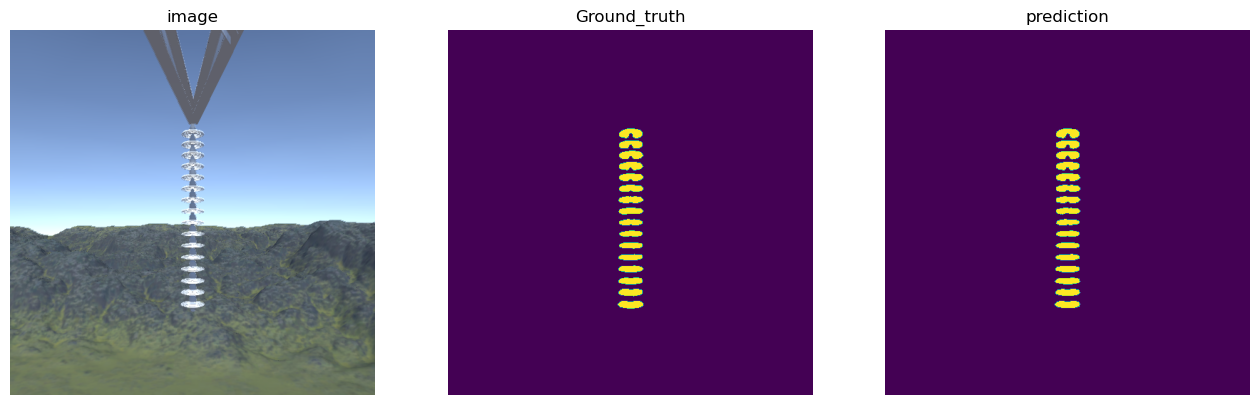

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg16_glass.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg16_glass.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_12468\1860365104.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

Linknet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()